In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import decoding_analysis_vis as dav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import xarray as xr
sns.set_palette('colorblind')

In [3]:
AllSes = dav.AllSessions(memory_efficient=True)

session name : 2020-09-04_RL093.pkl
No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally
Excluded 302 out of 2097 neurons
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons
Individual sessions loaded


In [4]:
tmpdata = AllSes.dataset_selector(AllSes, region='s2', trial_type_list=['sensory', 'sham', 'random'])

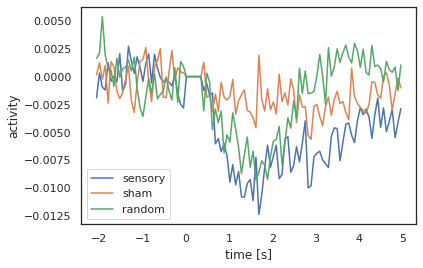

In [13]:
tt_list = ['sensory', 'sham', 'random']

for i_tt, tt in enumerate(tt_list):
    tmpdata.activity.where(tmpdata.trial_type == tt).mean(['neuron', 'trial']).plot(label=tt)

plt.legend()

In [ ]:
AllSes.